# Problem Set 3 - Linear Regression, Logistic Regression, and Naive Bayes
## CSCI 5622 - Spring 2023
***
**Name**: Jahoon Koo
***

This assignment is due on Canvas by **11:59PM on March 8**.

Submit only this Jupyter notebook to Canvas with the name format `PS3_<yourname>.ipynb`. Do not compress it using tar, rar, zip, etc.
Your solutions to analysis questions should be done in Markdown directly below the associated question. You can add a write-up markdown cell if it wasn't provided.

Remember that you are encouraged to discuss the problems with your classmates and instructors, 
but **you must write all code and solutions on your own**, and list any people or sources consulted.
The only exception to this rule is that you may copy code directly from your own solution to previous homeworks.
***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import data
%matplotlib inline

## Problem 1: Linear Regression (28 points)
For this problem we will be working with data on the compressive strength of concrete. The compressive strength of this ubiquitous material is a function of its age and ingredients. We will implement linear regression models to predict the compressive strength (in megapascals) from the following features:

| Feature | About |
| --- | --- |
| Cement | component 1, kg in 1 m^3 mixture  |
| Blast Furnace Slag | component 2, kg in 1 m^3 mixture  |
| Fly Ash | component 3, kg in 1 m^3 mixture  |
| Water | component 4, kg in 1 m^3 mixture  |
| Superplasticizer | component 5, kg in 1 m^3 mixture |
| Coarse Aggregate | component 6, kg in 1 m^3 mixture |
| Fine Aggregate | component 7, kg in 1 m^3 mixture |
| Age | component 8, days  |

First, we want to scale the strengths to the interval $[0, 1]$ using `MinMaxScaler`. Given an features matrix $X$, the scaling works as follows:
\begin{align}
    X  \leftarrow \frac{X-min(X)}{max(X) - min(X)}
\end{align}

this is performed as a column-wise operation (column = feature).

As usual, we compute $min(X)$ and $max(X)$ on the training set.

- 1.1.a **[2 points]** Complete `MinMaxScaler.fit` to compute and save the feature-wise min and max.
- 1.1.b **[1 points]** Complete `MinMaxScaler.transform` to apply the min-max scaling using the computed statistics.

In [2]:
class MinMaxScaler:

    def __init__(self):
        self.min = None
        self.max = None

    def fit(self, X):
        """
        Compute and save the features min and max of shape (num_features,)
        (you can also save them with shape (1, num_features))
        :param X: array of shape (num_samples, num_features)
        :return: fitted scaler
        """
        # Workspace 1.1.a
        #BEGIN 
        # code here
        self.min = np.min(X, axis=0)
        self.max = np.max(X, axis=0)
        #END
        return self

    def transform(self, X):
        """
        Transform the given samples using the precomputed min and max
        :param X: np.array of shape (num_samples, num_features)
        :return: MinMax scaled X, of shape (num_samples, num_features)
        """
        # Workspace 1.1.b
        #BEGIN 
        # code here
        
        X_scaled = (X - self.min) / (self.max - self.min)
        return X_scaled
        #END

    def fit_transform(self, X):
        """
        Fit using X and then transform it. Useful when we need to scale jsut once.
        """
        self.fit(X)
        return self.transform(X)

In [3]:
%run -i tests scaler

...
----------------------------------------------------------------------
Ran 3 tests in 0.005s

OK


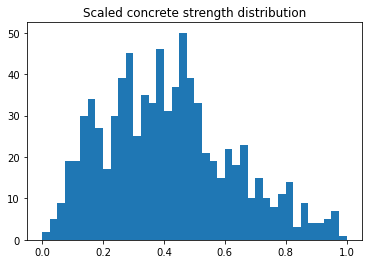

In [4]:
concrete_data = data.Concrete()
minmax_scaler = MinMaxScaler()
# MinMax works on 2-d arrays, so we just need to parse the prices as a single column/feature
# and then squeeze it back to 1-d array
concrete_data.y_train = minmax_scaler.fit_transform(concrete_data.y_train[:, None])[:, 0]
concrete_data.y_test = minmax_scaler.transform(concrete_data.y_test[:, None])[:, 0]
plt.hist(concrete_data.y_train, bins=40)
plt.title("Scaled concrete strength distribution")
plt.show()

We have seen that Ridge regression adds a regularization term to the least square using the L2 norm.
Ridge regression is part of scikit-learn package ([read more](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)), but we will be building our own implementation.
You can test your implementation against scikit's.

The objective of Ridge regression is to minimize:

\begin{align}
\frac{1}{N}\sum_{i=1}^{N} ||y_i-\mathbf{w}^T \mathbf{x_i}-\mathbf{b}||^2 + \alpha||\mathbf{w}||^2
\end{align}

where $\mathbf{w}$ denotes the coefficients vector for the linear regression model,
$\mathbf{b}$ the intercept vector, $\alpha$ the trade-off regularization parameter, and $N$ the number of samples.

Luckily for us, Ridge regression admits a closed form solution for $\mathbf w$ and $\mathbf{b}$.

Let $X$ be the $N\times d$ matrix whose rows are the training samples $(\mathbf{x_i})_{i\leq N}$ and $Y=(y_i)_{i\leq N}$ the target values.

First, we start by centering the features (columns of X) by subtracting the mean of the column to get centered matrix $\tilde{X}$. Then the solution for the minimization is (trust me):

\begin{align}
&\mathbf{w^*} = (\tilde{X}^T\tilde{X}+ \alpha I)^{-1}\tilde{X}^TY \\
&\mathbf{b^*} = \frac{1}{N} \sum_{i}^{i=N} (y_i - \mathbf{w^*}^T \mathbf{x_i})
\end{align}

Note that:
- $\mathbf{w}^*$ and $\mathbf{b}^*$ are the optimal weights and intercepts, respectively.
- The samples in $b^*$ are not centered.
- The predicted targets would be $\hat{y}_i = \mathbf{w^*}^T \mathbf{x_i}+\mathbf{b^*} $
- $\tilde{X}$ is only needed in the `fit` method when we compute $\mathbf{w^*}$ and $\mathbf{b^*}$

A common practice is to scale or normalize (usually normalize) the features before fitting the model. It allows a _fair_ treatment of different features.
You are allowed to use scikit's `StandardScaler` to do the normalization (yes, a thing called scaler is normalizing. Don't @ me, @ sklearn). Do not forget to run the same transformation on the test data before running the prediction.

- 1.2 **[5 points]** Complete the `fit` and `evaluate` methods following the provided descriptions.

In [5]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

class Ridge(object):

    def __init__(self, alpha, normalize=False):
        """
        :param alpha: regularization parameter
        :param normalize: boolean whether to normalize the features or not
        """

        self.alpha = alpha  # our tuning / regularization parameter
        self.coefficients = None  # our weights vector, w (in formulae above)
        self.intercept = None  # our intercept parameter, b (in formulae above)
        self.normalize = normalize  # boolean whether to normalize the features or not
        self.scaler = StandardScaler()  # method by which to normalize the features (depends on self.normalize)

    def fit(self, X, y):
        """
        Fit the ridge model, train it using the provided data
        Calculate the number of non-zero coefficients in the model weights and the norm using np.linalg.norm
        :param X: training features (num_samples, num_features)
        :param y: target values (num_samples)
        :return: tuple (number of non-zeros coefficients of w, norm of w)
        """
        num_nonzero_coefs, coef_norm = 0, 0
        
        # Normalize data with the scaler, if required
        if self.normalize:
            X = self.scaler.fit_transform(X)
        # Center the data
        X_center = X - np.mean(X, 0)
        
        # Workspace 1.2.a
        # TO DO: compute w and b and store them in self.coef_ and self.intercept
        #BEGIN 
        # code here
        n_samples, n_features = X.shape 
        
        I = np.eye(n_features, dtype=float)
        
        self.coefficients = np.dot(np.dot(np.linalg.inv(np.dot(X_center.T, X_center) + self.alpha * I), X_center.T), y)
        self.intercept = np.mean(y) - np.dot(self.coefficients.T, np.mean(X, 0))

        
        num_nonzero_coefs = np.count_nonzero(self.coefficients)
        coef_norm = np.linalg.norm(self.coefficients, ord=2)
        #END
        return num_nonzero_coefs, coef_norm

    def evaluate(self, X, y):
        """
        Compute Root mean square error (RMSE) between the predicted values and the actual values of the test data
        :param X: instances array of shape (num_samples, num_features)
        :param y: the true targets, of shape (num_samples)
        :return: RMSE
        """

        # Workspace 1.2.b
        # TO DO: predict based on the test features and return the root mean squared error
        #BEGIN 
        # code here
        self.fit(X, y)
        
        if self.normalize:
            X = self.scaler.fit_transform(X)
        y_pred = np.dot(self.coefficients, X.T) + self.intercept
        root_mean_squared_error = np.sqrt(np.mean((y - y_pred)**2))
        #END
        return root_mean_squared_error

In [6]:
# Tests cells, do not remove
# Should run without errors
%run -i tests ridge

....
----------------------------------------------------------------------
Ran 4 tests in 0.030s

OK


<Figure size 432x288 with 0 Axes>

- 1.3 **[3 points]** Produce 3 plots as a function of $\log_{10}(\alpha)$ (logarithmic scale) that compare normalized versus non-normalized Ridge:
    - The number of non-zero coefficients of $\mathbf w$
    - The norm of $\mathbf w$
    - The test RMSE (Root Mean Squared Error)

Use the values of $\alpha$ provided in the cell. What is the best `alpha` for each version of the two models?

To produce multiple plots in the same figure, see the examples [here](https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html)

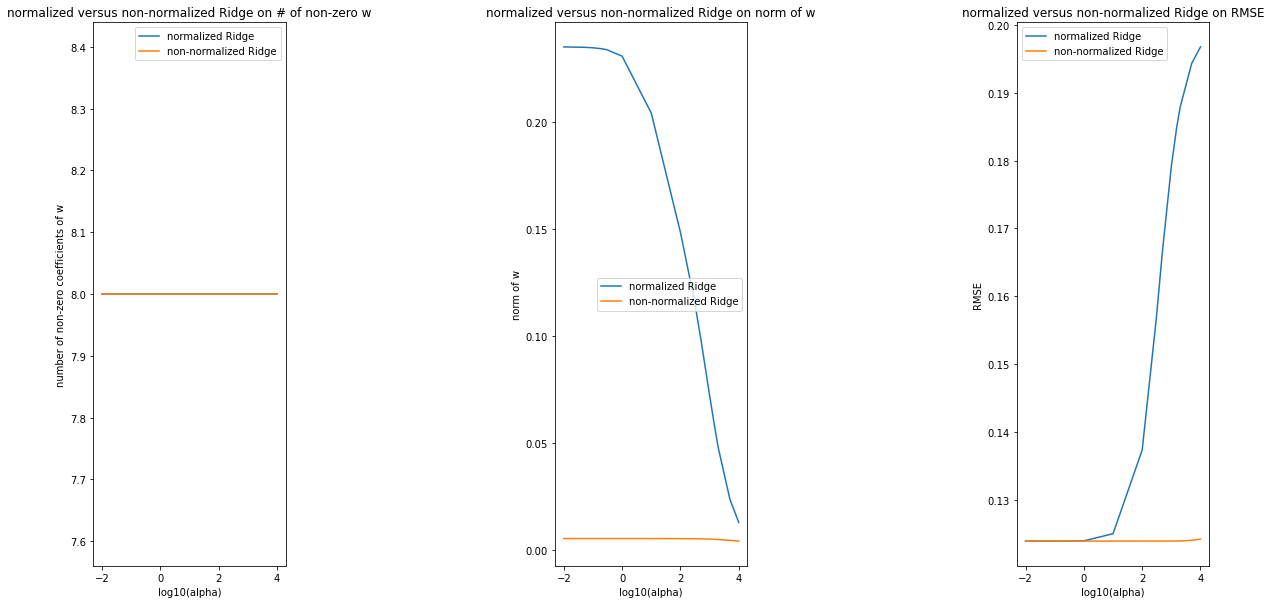

In [7]:
alphas = [0.01, 0.05, 0.1, 0.2, 0.3, 1.0, 10.0, 100.0, 300.0, 500.0, 1e3, 1.5e3, 2e3, 5e3, 1e4]
# Workspace 1.3
#BEGIN 
# code here
norm_num_nonzero_coefs = []
norm_coef_norms = []
norm_rmses = []

best_rmse_norm = 10000
best_rmse_non_norm = 10000

best_alpha_norm = -1
best_alpha_non_norm = -1

for alpha in alphas:
    norm_ridge = Ridge(alpha=alpha, normalize=True)
    num_nonzero_coefs, coef_norm = norm_ridge.fit(concrete_data.X_train, concrete_data.y_train)
    norm_num_nonzero_coefs.append(num_nonzero_coefs)
    norm_coef_norms.append(coef_norm)
    norm_rmse = norm_ridge.evaluate(concrete_data.X_test, concrete_data.y_test)
    
    if norm_rmse <= best_rmse_norm:
        best_rmse_norm = norm_rmse
        best_alpha_norm = alpha
        
    norm_rmses.append(norm_rmse)


non_norm_num_nonzero_coefs = []
non_norm_coef_norms = []
non_norm_rmses = []

best_rmse_non_norm = 10000
best_alpha_non_norm = -1

for alpha in alphas: 
    non_norm_ridge = Ridge(alpha=alpha, normalize=False)
    num_nonzero_coefs, coef_norm = non_norm_ridge.fit(concrete_data.X_train, concrete_data.y_train)
    non_norm_num_nonzero_coefs.append(num_nonzero_coefs)
    non_norm_coef_norms.append(coef_norm)
    non_norm_rmse = non_norm_ridge.evaluate(concrete_data.X_test, concrete_data.y_test)
    
    if non_norm_rmse <= best_rmse_non_norm:
        best_rmse_non_norm = non_norm_rmse
        best_alpha_non_norm = alpha
        
    non_norm_rmses.append(non_norm_rmse)


plt.figure(figsize=(20, 10))

plt.subplot(1, 5, 1)    
plt.plot(np.log10(alphas), norm_num_nonzero_coefs, label="normalized Ridge")
plt.plot(np.log10(alphas), non_norm_num_nonzero_coefs, label="non-normalized Ridge")
plt.xlabel("log10(alpha)")
plt.ylabel("number of non-zero coefficients of w")
plt.title("normalized versus non-normalized Ridge on # of non-zero w")
plt.legend()

plt.subplot(1, 5, 3)    
plt.plot(np.log10(alphas), norm_coef_norms, label="normalized Ridge")
plt.plot(np.log10(alphas), non_norm_coef_norms, label="non-normalized Ridge")
plt.xlabel("log10(alpha)")
plt.ylabel("norm of w")
plt.title("normalized versus non-normalized Ridge on norm of w")
plt.legend()
    
plt.subplot(1, 5, 5)
plt.plot(np.log10(alphas), norm_rmses, label="normalized Ridge")
plt.plot(np.log10(alphas), non_norm_rmses, label="non-normalized Ridge")
plt.xlabel("log10(alpha)")
plt.ylabel("RMSE")
plt.title("normalized versus non-normalized Ridge on RMSE")
plt.legend()
#END

In [8]:
print("The best alpha for normalized Ridge is {}.".format(best_alpha_norm))
print("The best alpha for non-normalized Ridge is {}.".format(best_alpha_non_norm))

The best alpha for normalized Ridge is 0.01.
The best alpha for non-normalized Ridge is 0.01.


#### Workspace 1.3b
#BEGIN

The best alpha for normalized Ridge is 0.01.
The best alpha for non-normalized Ridge is 0.01.


#END

Based on the results from previous questions, you should have noticed that the interpretation of Ridge regression is not an easy task.
One way to solve that is to use a regularization that adds _sparsity_ to $\mathbf w$ and excludes less important features.
That's what Lasso regression is about.

Lasso uses $l_1$ norm in the regularization term and minimizes:
\begin{align}
\frac{1}{2N}\sum_i ||y_i-\mathbf{w}^T \mathbf{x}_i -\mathbf{b}||^2 + \alpha||\mathbf{w}||_1
\end{align}

It is part of scikit package ([more details](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html))
and you're free to compare your implementation to scikit's.

Unfortunately, there is no closed form solution for Lasso. Instead, we have powerful algorithms to optimize it.
We will be using lasso-path solver from scikit-learn for our implementation to find $\mathbf w^*$
([see more](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.lasso_path.html#sklearn.linear_model.lasso_path)).
(Note that `lasso_path` takes a list of $\alpha$ in the argument `alphas` and not a scalar.)

Similar to Ridge's, $ \mathbf w^*_{lasso} $ is computed by feeding the centered $\tilde{X}$ to `lasso_path`.
Once $\mathbf w^*$ is found, $\mathbf{b}^*$ has the same formula from Ridge regression.

- 1.4 **[4 points]** Complete the Lasso class in the same way Ridge class was created. (You're allowed to use inheritance for a more concise code, as long as the class has `coefficients` and `intercept` attributes.)

In [9]:
from sklearn.linear_model import lasso_path


class Lasso(object):
    def __init__(self, alpha, normalize=False):
        """
        :param alpha: regularization parameter
        :param normalize: boolean whether to normalize the features or not
        """
        self.alpha = alpha  # our tuning / regularization parameter
        self.coefficients = None  # our weights vector, w (in formulae above)
        self.intercept = None  # our intercept parameter, b (in formulae above)
        self.normalize = normalize  # boolean whether to normalize the features or not
        self.scaler = StandardScaler()  # method by which to normalize the features (depends on self.normalize)

    def fit(self, X, y):
        """
        Fit the lasso model, train it using the provided data
        Calculate the number of non-zero coefficients in the model weights and the norm using np.linalg.norm
        :param X: training features (num_samples, num_features)
        :param y: target values (num_samples)
        :return: tuple (number of non-zeros coefficients of w: scalar, norm of w: scalar)
        """
        
        num_nonzero_coefs, coef_norm = 0, 0
        
        # Normalize data with the scaler, if required
        if self.normalize:
            X = self.scaler.fit_transform(X)
        # Center the data
        X_center = X - np.mean(X, 0)
        
        # Workspace 1.4.a
        # TO DO: compute w and b and store then in self.coef_ and self.intercept
        # TO DO: call lasso_path on the centered features to compute self.coef_
        #BEGIN 
        # code here
        
        # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.lasso_path.html#sklearn.linear_model.lasso_path
        _, coefs, _ = lasso_path(X_center, y, alphas=[self.alpha])
        self.coefficients = coefs[:, 0]
        self.intercept = np.mean(y) - np.dot(self.coefficients.T, np.mean(X, 0))

        num_nonzero_coefs = np.count_nonzero(self.coefficients)
        coef_norm = np.linalg.norm(self.coefficients, ord=1)
        
        #END
        return num_nonzero_coefs, coef_norm

    def evaluate(self, X, y):
        """
        Compute Root mean square error (RMSE) between the predicted values and the actual values  of the test data
        :param X: features array, shape (num_samples, num_features)
        :param y: true targets, shape (num_samples)
        :return: RMSE
        """
        root_mean_squared_error = 0
        # Workspace 1.4.b
        # TO DO: predict based on the test features and return the mean_squared_error
        #BEGIN 
        self.fit(X, y)
        
        if self.normalize:
            X = self.scaler.fit_transform(X)
        y_pred = np.dot(self.coefficients, X.T) + self.intercept
        root_mean_squared_error = np.sqrt(np.mean((y - y_pred)**2))
        #END
        return root_mean_squared_error

In [10]:
# Tests cell, do not remove
# Test non-normalized Lasso
%run -i tests lasso

....
----------------------------------------------------------------------
Ran 4 tests in 0.009s

OK


<Figure size 432x288 with 0 Axes>

- 1.5 **[3 points]** Produce 3 plots as a function of $\log_{10}(\alpha)$ (logarithmic scale) that compare normalized versus non-normalized Lasso:
    - The number of non-zero coefficients of $\mathbf w$
    - The norm of $\mathbf w$
    - The test RMSE (Root Mean Squared Error)

Use the values of $\alpha$ provided in the cell. What is the best `alpha` for each version of the two models?

Can you get all coefficients of $\mathbf w$ to 0 for the non-normalized Lasso?


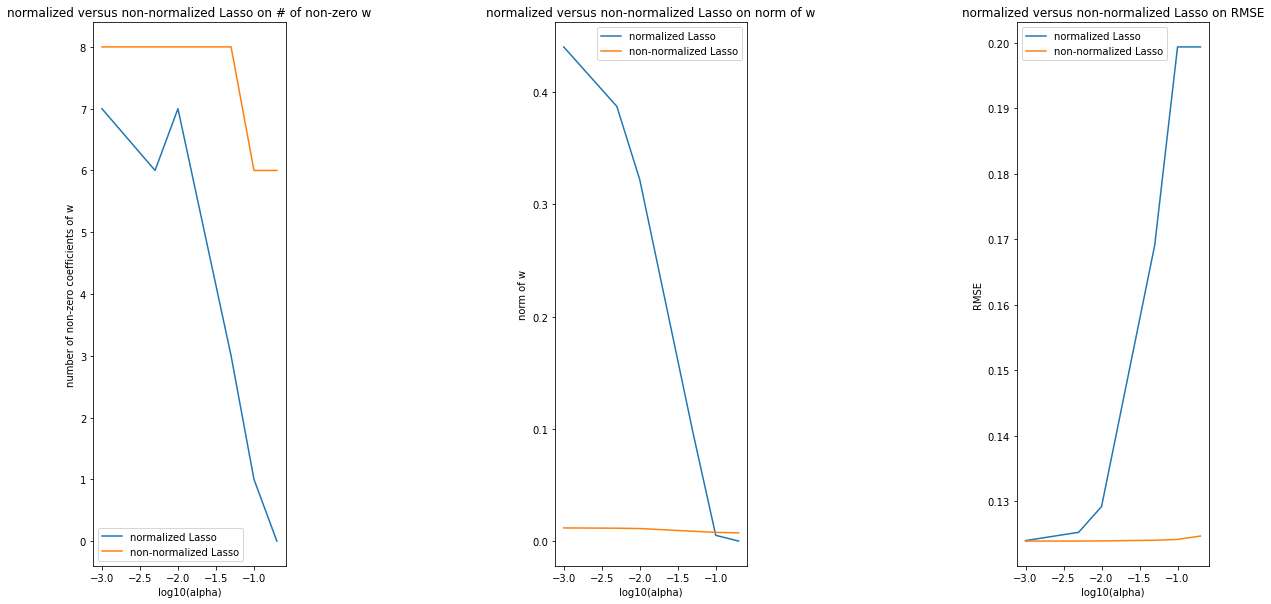

In [11]:
alphas = [1e-3, 5e-3, 0.01, 0.05, 0.1, 0.2]
# Workspace 1.5
#BEGIN 
norm_num_nonzero_coefs = []
norm_coef_norms = []
norm_rmses = []

best_rmse_norm = 10000
best_rmse_non_norm = 10000

best_alpha_norm = -1
best_alpha_non_norm = -1

for alpha in alphas:
    norm_lasso = Lasso(alpha=alpha, normalize=True)
    num_nonzero_coefs, coef_norm = norm_lasso.fit(concrete_data.X_train, concrete_data.y_train)
    norm_num_nonzero_coefs.append(num_nonzero_coefs)
    norm_coef_norms.append(coef_norm)
    norm_rmse = norm_lasso.evaluate(concrete_data.X_test, concrete_data.y_test)
    
    if norm_rmse <= best_rmse_norm:
        best_rmse_norm = norm_rmse
        best_alpha_norm = alpha
        
    norm_rmses.append(norm_rmse)


non_norm_num_nonzero_coefs = []
non_norm_coef_norms = []
non_norm_rmses = []

best_rmse_non_norm = 10000
best_alpha_non_norm = -1

for alpha in alphas: 
    non_norm_lasso = Lasso(alpha=alpha, normalize=False)
    num_nonzero_coefs, coef_norm = non_norm_lasso.fit(concrete_data.X_train, concrete_data.y_train)
    non_norm_num_nonzero_coefs.append(num_nonzero_coefs)
    non_norm_coef_norms.append(coef_norm)
    non_norm_rmse = non_norm_lasso.evaluate(concrete_data.X_test, concrete_data.y_test)
    
    if non_norm_rmse <= best_rmse_non_norm:
        best_rmse_non_norm = non_norm_rmse
        best_alpha_non_norm = alpha
        
    non_norm_rmses.append(non_norm_rmse)


plt.figure(figsize=(20, 10))

plt.subplot(1, 5, 1)    
plt.plot(np.log10(alphas), norm_num_nonzero_coefs, label="normalized Lasso")
plt.plot(np.log10(alphas), non_norm_num_nonzero_coefs, label="non-normalized Lasso")
plt.xlabel("log10(alpha)")
plt.ylabel("number of non-zero coefficients of w")
plt.title("normalized versus non-normalized Lasso on # of non-zero w")
plt.legend()

plt.subplot(1, 5, 3)    
plt.plot(np.log10(alphas), norm_coef_norms, label="normalized Lasso")
plt.plot(np.log10(alphas), non_norm_coef_norms, label="non-normalized Lasso")
plt.xlabel("log10(alpha)")
plt.ylabel("norm of w")
plt.title("normalized versus non-normalized Lasso on norm of w")
plt.legend()
    
plt.subplot(1, 5, 5)
plt.plot(np.log10(alphas), norm_rmses, label="normalized Lasso")
plt.plot(np.log10(alphas), non_norm_rmses, label="non-normalized Lasso")
plt.xlabel("log10(alpha)")
plt.ylabel("RMSE")
plt.title("normalized versus non-normalized Lasso on RMSE")
plt.legend()
#END

In [12]:
print("The best alpha for normalized Lasso is {}.".format(best_alpha_norm))
print("The best alpha for non-normalized Lasso is {}.".format(best_alpha_non_norm))

The best alpha for normalized Lasso is 0.001.
The best alpha for non-normalized Lasso is 0.001.


#### Workspace 1.5b
%BEGIN

The best alpha for normalized Ridge is 0.001.

The best alpha for non-normalized Ridge is 0.001.

Yes, you can get all coefficients of 𝐰 to 0 for the non-normalized Lasso as alpha increases. With the alpha values provided in the cell, number of non-zero coefficients of w stops at 6. However, as the alpha value increases beyond the provided values, it eventaully reaches to 0 for all coefficients of w.  

%END

- 1.6 **[3 points]** (Write-up) Compare the two algorithms on the concrete strength dataset: compare the number of non-zero coordinates of Ridge vs Lasso and their RMSE on each dataset. Which type of regression is better? When does normalization improve the RMSE?



#### Workspace 1.6

%BEGIN

Number of non-zero coordinates of Ridge is constant (which is 8) for all alpha values regardless of the status of normalization. Number of non-zero coordinates of normalized Lasso is 7 and non-normalized Lasso is 8 when RMSE is the lowest. Normalized Lasso has performed feature selection by setting some coefficients to zero. They both have the lowest RMSE when the alpha value is the smallest. Since they both have the same lowest RMSE value, it's hard to tell which type of regression is better than the other. However, normalized Lasso is using less features than Ridge, so I would say Lasso is better. 

Normalization increases the RMSE when alpha value is high. 
 
%END

Lasso is expected to have higher level of sparsity compared to Ridge. On the other hand, when the number of features is very large
(larger than the sample size), Lasso can struggle at picking the right features.
Elastic Net try to combine both types of regularization to get the best of both worlds by minimizing:

\begin{align}
\frac{1}{2N} \sum_i ||y_i - \mathbf{w}^T\mathbf{x}_i -\mathbf{b}||^2_2 + \alpha\beta||\mathbf{w}||_1 + \frac{\alpha}{2}(1 - \beta)||\mathbf{w}||^2_2
\end{align}

where $\beta\in[0,1]$ is the $l_1$ ratio ($\beta=1$ for Lasso and $\beta=0$ for Ridge).

We'll be using [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) solver from scikit.

- 1.7 **[2 points]** Complete ElasticNet regression class `Elastic` by implementing fit and evaluate methods with the same signature as Lasso and Ridge. (Again, you can use inheritance)

In [13]:
from sklearn.linear_model import ElasticNet


class Elastic(object):
    def __init__(self, alpha, beta=0.5, normalize=False):
        """
        :param alpha: regularization parameter
        :param beta: l1_ratio for ElasticNet
        :param normalize: normalization flag
        """
        self.alpha = alpha
        self.beta = beta
        self.normalize = normalize
        self.scaler = StandardScaler()
        self.coefficients = None
        self.intercept = None
        self._model = ElasticNet(alpha=alpha, l1_ratio=beta)

    def fit(self, X, y):
        """
        fit self._model using the provided data and store the coef and intercept in self.coef_ and self.intercept
        Calculate the number of non-zero coefficients in the model weights and the norm using np.linalg.norm
        :param X: training features (n_samples, n_features)
        :param y: target values (n_samples)
        :return: tuple (number of non-zeros coefficients of w, norm of w)
        """
        num_nonzero_coefs, coef_norm = 0, 0
        
        # Normalize data with the scaler, if required
        if self.normalize:
            X = self.scaler.fit_transform(X)
            
        # Workspace 1.7.a
        # TO DO: Complete Elastic Net
        # TO DO: save w and b in self.coef_ and self.intercept respectively
        #BEGIN 
        # code here
        
        # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html
        self._model.fit(X, y)
        self.coefficients = self._model.coef_
        self.intercept = self._model.intercept_
        
        num_nonzero_coefs = np.count_nonzero(self.coefficients)
        coef_norm = np.linalg.norm(self.coefficients)
        #END
        return num_nonzero_coefs, coef_norm

    def evaluate(self, test_x, test_y):
        """
        Compute Root mean square error (RMSE) between the predicted values and the actual values  of the test data
        :param test_x: test features
        :param test_y: test target
        :return: RMSE
        """

        root_mean_squared_error = 0
        # TO DO: predict based on the test features and return the mean_squared_error
        # Workspace 1.7.b
        #BEGIN 
        # code here
        self.fit(test_x, test_y)
        
        if self.normalize:
            test_x = self.scaler.fit_transform(test_x)
        y_pred = np.dot(self.coefficients, test_x.T) + self.intercept
        root_mean_squared_error = np.sqrt(np.mean((test_y - y_pred)**2))
        #END
        return root_mean_squared_error

In [14]:
# Tests cell, do not remove
%run -i tests elastic

....
----------------------------------------------------------------------
Ran 4 tests in 0.007s

OK


<Figure size 432x288 with 0 Axes>

- 1.8 **[2 points]** Produce 3 plots as a function of $\log_{10}(\alpha)$ (logarithmic scale) that compare normalized versus non-normalized `Elastic`:
    - The number of non-zero coefficients of $\mathbf w$
    - The norm of $\mathbf w$
    - The test RMSE (Root Mean Squared Error)

Use the values of $\alpha$ provided in the cell, and $\beta= 0.3$. What is the best `alpha` for each version of the two models? How does it compare to the previous models.


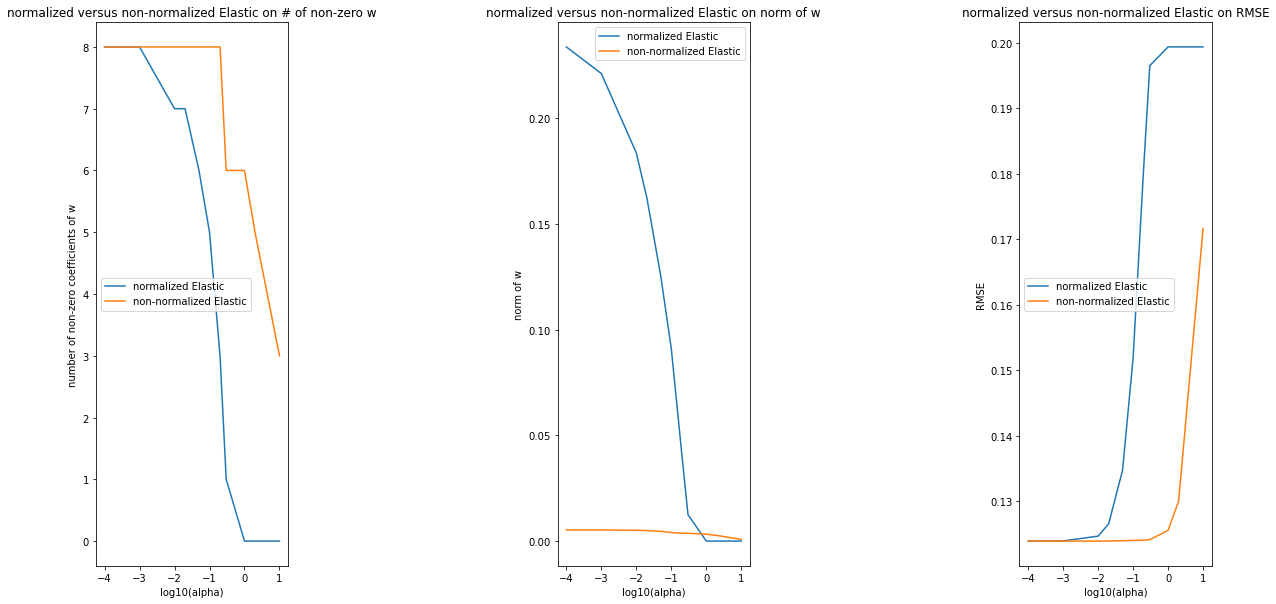

In [15]:
alphas = [1e-4, 1e-3, 1e-2, 0.02, 0.05, 0.1, 0.2, 0.3, 1.0, 2.0, 10.0]
beta = 0.3
# Workspace 1.2
#BEGIN 
# code here

norm_num_nonzero_coefs = []
norm_coef_norms = []
norm_rmses = []

best_rmse_norm = 10000
best_rmse_non_norm = 10000

best_alpha_norm = -1
best_alpha_non_norm = -1

for alpha in alphas:
    norm_elastic = Elastic(alpha=alpha, beta=beta, normalize=True)
    num_nonzero_coefs, coef_norm = norm_elastic.fit(concrete_data.X_train, concrete_data.y_train)
    norm_num_nonzero_coefs.append(num_nonzero_coefs)
    norm_coef_norms.append(coef_norm)
    norm_rmse = norm_elastic.evaluate(concrete_data.X_test, concrete_data.y_test)
    
    if norm_rmse <= best_rmse_norm:
        best_rmse_norm = norm_rmse
        best_alpha_norm = alpha
        
    norm_rmses.append(norm_rmse)


non_norm_num_nonzero_coefs = []
non_norm_coef_norms = []
non_norm_rmses = []

best_rmse_non_norm = 10000
best_alpha_non_norm = -1

for alpha in alphas: 
    non_norm_elastic = Elastic(alpha=alpha, beta=beta, normalize=False)
    num_nonzero_coefs, coef_norm = non_norm_elastic.fit(concrete_data.X_train, concrete_data.y_train)
    non_norm_num_nonzero_coefs.append(num_nonzero_coefs)
    non_norm_coef_norms.append(coef_norm)
    non_norm_rmse = non_norm_elastic.evaluate(concrete_data.X_test, concrete_data.y_test)
    
    if non_norm_rmse <= best_rmse_non_norm:
        best_rmse_non_norm = non_norm_rmse
        best_alpha_non_norm = alpha
        
    non_norm_rmses.append(non_norm_rmse)


plt.figure(figsize=(20, 10))

plt.subplot(1, 5, 1)    
plt.plot(np.log10(alphas), norm_num_nonzero_coefs, label="normalized Elastic")
plt.plot(np.log10(alphas), non_norm_num_nonzero_coefs, label="non-normalized Elastic")
plt.xlabel("log10(alpha)")
plt.ylabel("number of non-zero coefficients of w")
plt.title("normalized versus non-normalized Elastic on # of non-zero w")
plt.legend()

plt.subplot(1, 5, 3)    
plt.plot(np.log10(alphas), norm_coef_norms, label="normalized Elastic")
plt.plot(np.log10(alphas), non_norm_coef_norms, label="non-normalized Elastic")
plt.xlabel("log10(alpha)")
plt.ylabel("norm of w")
plt.title("normalized versus non-normalized Elastic on norm of w")
plt.legend()
    
plt.subplot(1, 5, 5)
plt.plot(np.log10(alphas), norm_rmses, label="normalized Elastic")
plt.plot(np.log10(alphas), non_norm_rmses, label="non-normalized Elastic")
plt.xlabel("log10(alpha)")
plt.ylabel("RMSE")
plt.title("normalized versus non-normalized Elastic on RMSE")
plt.legend()
#END

In [16]:
print(norm_rmses)
print(non_norm_rmses)

[0.12389025566231388, 0.12391569855611706, 0.12464356915293015, 0.12651653791040587, 0.1347152084240052, 0.15180426876503506, 0.1807661142953074, 0.19648579966803711, 0.1993545118770868, 0.1993545118770868, 0.1993545118770868]
[0.12388971510126554, 0.12388974009282745, 0.123892236038518, 0.12389978564334858, 0.12395239972186146, 0.12398909929476433, 0.12403630551031851, 0.12411488803041668, 0.12551428666225659, 0.1299785708992995, 0.17162365688793604]


In [17]:
print("The best alpha for normalized Elastic is {}.".format(best_alpha_norm))
print("The best alpha for non-normalized Elastic is {}.".format(best_alpha_non_norm))

The best alpha for normalized Elastic is 0.0001.
The best alpha for non-normalized Elastic is 0.0001.


#### Workspace 1.8.b

%BEGIN

The best alpha for normalized Elastic is 0.0001.

The best alpha for non-normalized Elastic is 0.0001.

Previous models also have the best performance when alpha is the lowest. Normalized verision of all three models have higher RMSE as alpha value increases.  Also, You can get all coefficients of 𝐰 to 0 for the non-normalized Elastic as well if alpha is set to a large value.

%END

1.9 **[3 points]** What are the pros and cons of each of the three types of regressions we have tested?

#### Workspace 1.9

%BEGIN

Ridge

- Pros: 
Easy to implement and computationally efficient because Ridge regression admits a closed form solution for 𝐰 and 𝐛.
       
- Cons: 
Ridge regression doesn't perform feature selection, so it may keep irrelevant features that affects the performance.
Ridge regression requires the optimal value of the alpha to be selected. If alpha is too small, then the model might be still overfitting. If alpha is too large, then the model might be underfitting. 

Lasso

- Pros: 
Lasso regression performs feature selection by setting some of the coefficients to zero.
Lasso regression can use alpha to control the sparsity of the model. As you can see from the number of non-zero coefficients of w for Lasso regression, its sparsity changes based on different alpha value. 


- Cons:
Lasso regression may not be effective when there are many features. It may remove useful features from the model and increases bias. 
Cannot handle a small dataset with high dimensionality.
Compared to Ridge regression, Lasso regression can be more computationally expensive and harder to implement because there is no closed form solution for 𝐰 and 𝐛.

Elastic

- Pros: 
Combines L1 and L2 regulazations.
Can handle a small dataset with high dimensionality since it uses both L1 and L2 regulazations.
Better feature selections than Lasso as you can see that Elastic has better performance than Lasso when they have the same number of non-zero coefficients of w.


- Cons: 
Need to tune alpha and beta (hyperparameters) appropriates to get the best performance.
Compared to Ridge and Lasso, it can be more computationally expensive since it uses both L1 and L2 regulazations.


%END

***
## Problem 2: Logistic Regression for Binary Classification (30 points)

The second part of this assignment will be dealing with Logistic Regression.
While the name "regression" suggests otherwise, Logistic Regression is actually used for classification.
It's a regression problem because the targets are the continuous likelihoods of the outcomes.

We will use the MNIST digits dataset for this problem.
Let's start with a simple case for binary Logistic Regression: Our class label will be `1` if a sample is an odd number and `0` otherwise.

In [18]:
binary_digits = data.BinaryDigits()

In [19]:
unique, counts = np.unique(binary_digits.y_train, return_counts=True)

print(unique)  
print(counts)  

[0 1]
[479 521]


Using the same notations from Problem 1 (this time with discrete targets $y_i$ in {0, 1}), _Logistic Regression_ is about minimizing the **N**egative **L**og **L**ikelihood objective defined as:
\begin{align}
\textrm{NLL}(\mathbf{w}) = -\frac{1}{N}\sum_{i=1}^N \left[y_i \log \sigma({\mathbf{x_i}\mathbf{w}^T}) + (1-y_i)\log(1 - \sigma(\mathbf{x_i}\mathbf{w}^T))\right]
\end{align}

You might be wondering: where is the intercept?
We're including the intercept in $(\mathbf x_i)_i$ since we'll be adding a constant feature $\mathbf x_{i,0} = 1$ to all samples $(\mathbf x_i)_i$.
We will call it the zero-th column and the intercept will be $\mathbf{w}_0$.
This zero-th column will be appended to the training samples in `fit` method and the test samples in `predict` method. $\sigma$ is the sigmoid function seen in class.

The gradient of **NLL** w.r.t $\mathbf{w}$ is:

\begin{align}
\frac{\partial \textrm{NLL}}{\partial \mathbf{w}} = \frac{1}{N} \sum_i \left[\sigma(\mathbf{x}_i\mathbf{w}^T)-y_i)\right]\mathbf{x}_i
\end{align}

- 2.1 **[3 points]** Complete the `sigmoid` function to return the sigmoid values $\sigma({\mathbf{x_i}\mathbf{w}^T})$ given features array. You have to truncate the score ${\mathbf{x_i}\mathbf{w}^T}$ to the interval $[-25, 25]$ to avoid overflow of `np.exp`. *Hint: Pass only x to this function, and perform the matrix multiplication with w inside the function.*


- 2.2 **[3 points]** Finish the `compute_gradient` function to return the derivative of the cost with respect to the weights

- 2.3 **[3 points]** Finish the `batch_update` function so that it performs batch gradient descent using the provided batch data

- 2.4 **[4 points]** Finish the `fit` function so that it performs several training epochs and returns the Recall score on the validation data at the end of each epoch. Initialize $\mathbf{w}$ so that $\mathbf{w}_j = \frac{1}{d}$

- 2.5 **[2 points]** Finish the `predict` method to return the predicted labels (either 0 or 1)


In [20]:
from sklearn.metrics import recall_score

class LogisticRegression:

    def __init__(self, eta=0.1, alpha=0):
        """
        Create a logistic regression classifier
        :param eta: Learning rate
        :param alpha: We will use this parameter later (IN BONUS)
        """

        self.w = None  # uninitialized w
        self.eta = eta  # learning rate
        self.initialized = False # flag used to initialize w only once, it allows calling fit multiple times
        self.alpha = alpha  # regularization / penalty term (USED IN BONUS)

    def sigmoid(self, x, threshold=25.0):
        """

        :param x: features array of shape (num_samples, num_features + 1) (zero-th column appended)
        :param threshold: the truncating threshold for np.exp, default 
        
        
        to 25.0
        :return: sigmoid values , of shape (num_samples,)
        """
        # Workspace 2.1
        # TO DO: Complete this function to return the output of applying the sigmoid function to the score
        #BEGIN 
        # code here
        x = np.dot(x, self.w)
        x = np.clip(x, -threshold, threshold)
        sigmoid = 1 / (1 + np.exp(-x))
        return sigmoid
        #END

    def compute_gradient(self, x, y):
        """
        Return the derivative of the cost w.r.t to the weights. Don't forget to average by batch_size
        :param x:  Feature vector, shape (batch_size, num_features +1), with zero-th column appended
        :param y: real binary class label, shape (batch_size)
        :return: gradient of shape (num_features + 1,)
        """

        # Workspace 2.2
        # TO DO: Finish this function to compute the gradient
        gradient = np.zeros((x.shape[1], ))
        #BEGIN 
        # code here
        n_samples, n_features = x.shape
        y_pred = self.sigmoid(x)
        gradient = 1/n_samples * np.dot(x.T, (y_pred - y)) 
        #END
        return gradient

    def batch_update(self, batch_x, batch_y):
        """
        Single self.w update using the batch.
        :param batch_x: array of features (includes the constant feature at column 0), of shape (batch_size, num_features + 1)
        :param batch_y: array of target values, shape (batch_size,)
        :return: nothing
        """

        # Workspace 2.3
        #BEGIN 
        # code here
        gradient = self.compute_gradient(batch_x, batch_y)
        self.w = self.w - (self.eta * gradient)
        
        
        #END

    def fit(self, X, y, epochs=1, batch_size=1, validation_X=None, validation_y=None):
        """
        train the LogisticRegression
        :param X: training features, shape (num_samples, num_features)
        :param y: training labels, shape (num_samples,)
        :param epochs: number of epochs, integer
        :param batch_size: size of batch for gradient update, 1 for SGD
        :param validation_X: validation rows, should default to training data if not provided
        :param validation_y: validation labels
        :return: recall score at the end of each epoch on validation data
        """

        if validation_X is None:
            validation_X, validation_y = X, y
        metrics = []
        
        # Prepend constant feature to data
        X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        
        # initialize weights
        if not self.initialized:
            self.w = np.ones(X.shape[1]) / X.shape[1]
            self.initialized = True
        
        # Workspace  2.4
        # TO DO: Process X to append the zero-th constant column and call self.optimize
        # TO DO: Compute average recall on the validation data at the end of each epoch
        #BEGIN 
        # code here
        
        for i in range(epochs):
            self.optimize(X, y, batch_size)
            
            y_pred_val = self.predict(validation_X)
            score = recall_score(validation_y, y_pred_val)      
            metrics.append(score)        
        
        #END
        return np.array(metrics)

    def predict(self, X):
        """
        :param X: features array, shape (num_samples, num_features) (without the constant column)
        :return: predicted binary label, shape (num_samples,)
        """
        # Workspace 2.5
        y_hat = np.zeros((X.shape[0],))
        X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)  # We append zero-th column
        #BEGIN 
        y_hat = self.sigmoid(X)
        
        # https://stackoverflow.com/questions/19666626/replace-all-elements-of-python-numpy-array-that-are-greater-than-some-value
        y_hat[y_hat > 0.5] = 1
        y_hat[y_hat <= 0.5] = 0
        y_hat = y_hat.astype(int)
        #END
        return y_hat

    def optimize(self, X, y, batch_size):
        """
        Perform one epoch batch gradient on shuffled data
        :param X: np.array of shape (num_samples, num_features +1), The training data with zero-th column appended
        :param y: target values of shape (num_samples,)
        :param batch_size: batch_size of the batch_update
        :return: None
        """
        indices = np.random.permutation(len(X))
        for i in range(0, X.shape[0], batch_size):
            batch_x = X[indices[i:i + batch_size]]
            batch_y = y[indices[i:i + batch_size]]
            self.batch_update(batch_x, batch_y)

After completing the class above, loop over the training data and perform batch training with `batch_size=1`(Stochastic Gradient Descent) for 50 epochs, and different values of eta ( see `etas`). Train your model and do the following:

- 2.6 **[5 points]** Plot the recall trend for the different values of eta on the training data (epoch vs recall). (reset random seed for each loop to mitigate the randomness effect)

Use the values provided below

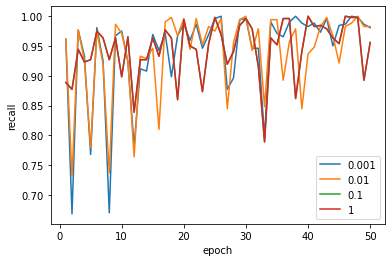

In [21]:
etas = [.001, .01, 0.1, 1]

recalls = {} 

for eta in etas:
    np.random.seed(2022)  # Reset randomness
    # Workspace 2.6
    #BEGIN 
    # code here
    logistic_regression = LogisticRegression(eta=eta, alpha=0)
    recall = logistic_regression.fit(binary_digits.X_train, binary_digits.y_train, epochs=50, batch_size=1)
    recalls[eta] = recall
     
    plt.plot([i+1 for i in range(50)], recall, label=str(eta))
    #END
    
#plt.plot([i for i in range(1, 51)], recalls, label="normalized Elastic")
#plt.plot(np.log10(alphas), non_norm_rmses, label="non-normalized Elastic")
plt.xlabel("epoch")
plt.ylabel("recall")
plt.legend()
plt.show()

- 2.7 **[3 points]** Plot the recall trend for the different values of eta on the test data.
(reset random seed for each loop to mitigate the randomness effect)

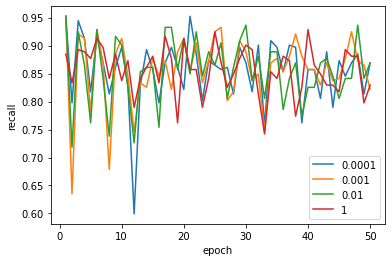

In [22]:
etas = [.0001, .001, .01, 1]

for eta in etas:
    np.random.seed(2022)
    # Workspace 2.7
    #BEGIN 
    logistic_regression = LogisticRegression(eta=eta, alpha=0)
    recall = logistic_regression.fit(binary_digits.X_train, binary_digits.y_train, epochs=50, batch_size=1, validation_X=binary_digits.X_test, validation_y=binary_digits.y_test)
    plt.plot([i+1 for i in range(50)], recall, label=str(eta))
    #END
plt.xlabel("epoch")
plt.ylabel("recall")
plt.legend()
plt.show()

This time we want to analyze the effect of varying the batch size. We fix `eta=0.01` and `epochs=50` and we want to
examine the recall on the test set at the end of the training.

- 2.8 **[4 points]** Produce a plot of the recall on the test data at the end of the training as a function of the batch size. Reset the random generator for each iteration.

Use batch sizes provided below

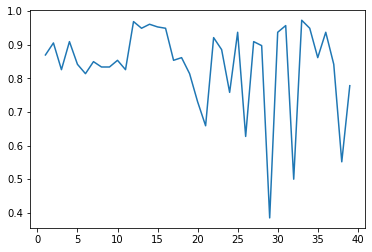

In [23]:
batch_sizes = list(range(1, 40))
recalls = []

for b_size in batch_sizes:
    np.random.seed(2022)
    # Workspace 2.8
    #BEGIN 
    # code here
    logistic_regression = LogisticRegression(eta=0.01, alpha=0)
    recall = logistic_regression.fit(binary_digits.X_train, binary_digits.y_train, epochs=50, batch_size=b_size)
    y_pred = logistic_regression.predict(binary_digits.X_test)
    recalls.append(recall_score(binary_digits.y_test, y_pred))
    #END
plt.plot(batch_sizes, recalls)
plt.show()

2.9 **[3 points]** How does the learning rate (eta) and the number of epochs affect the performance of the classifier.

#### Workspace 2.9

%BEGIN

If the learning rate is too high, the algorithm might miss the best solution and fail to converge. The algorithm may take too long to converge or become stuck in a local minimum if the learning rate is too low. As you can see from the graph above, the model doesn't converge for the highest learning rate, resulting in poor performance compared to other learning rates. Also, the model does not have the best performance for the smallest learning rate either because it can become stuck in a local minimum.

If the number of epochs is set too high, the model may overfit and perform poorly on the test dataset. If the number of epochs is too low, the model may not have enough time to converge, resulting in underfitting and poor performance.


%END

2.10 (**Bonus**) **[4 points]** Since we're done with the binary regression, we will try to add Ridge regularization:
\begin{align}
\textrm{NLL}(\mathbf{w}) = -\frac{1}{N}\sum_{i=1}^N \left[y_i \log \sigma(\mathbf{w}^T{\mathbf{x}_i}) + (1-y_i)\log(1 - \sigma(\mathbf{w}^T\mathbf{x}_i))\right] + \alpha {||\mathbf{w}||^2}_{\geq1}
\end{align}

This is exactly what we will be using the `alpha` parameter in `LogisticRegression` for.
First, write the gradient formula in the cell below and edit your `compute_gradient` to account for the regularization term. Note that the regularization $||\mathbf{w}||^2$ does not apply to the intercept $\mathbf{w}_0$

#### Workspace 2.10

%BEGIN

% YOUR ANSWER HERE

%END



## Problem 3: Logistic Regression for Multiclass Classification (24 Points)
***
You will now create a classifier that is commonly referred to as _One Versus All_ Logistic Regression,
where a binary classifier will be trained to identify a single class. The prediction is performed by assigning the label
of the classifier that is most confident in its prediction (the highest score/sigmoid value).

The dataset will be the same one we use in Problem Set 1's KNNClassifier

In [24]:
from sklearn.preprocessing import StandardScaler
digits = data.Digits()
scaler = StandardScaler()
digits.X_train = scaler.fit_transform(digits.X_train)
digits.X_test = scaler.transform(digits.X_test)

In [25]:
unique_values, value_counts = np.unique(digits.y_train, return_counts=True)
print(np.sum(value_counts))
print(digits.y_train.shape[0])

1000
1000


- 3.1 **[3 points]** Complete `one_hot_encoding` to transform your integer labels into a set of binary features via one-hot encoding.
You can assume that it's called after `label_to_index` and `index_to_label` have been defined.


- 3.2 **[2 points]** Complete `normalize_data` to normalize your features. You can use `StandardScaler`
- 3.3 **[4 points]** Complete `predict` method to return the predicted label using the scores from each class classifier.
You might be tempted to call `LogisticRegression.predict`, but you need the sigmoid values to determine the most likely label (and hence have to add the zero-th column in OneVersusAll).

- 3.4 **[2 points]** Complete `evaluate` to return the weighted average recall (WAR) on the validation data (use `recall_score`)
- 3.5 **[6 points]** Complete `fit` function to fit all classifiers with their corresponding labels and compute the WAR at the end of each epoch

Reminder: make no assumption about the number of features/classes in the data.

In [26]:
class OneVersusAll(object):

    def __init__(self, eta=0.1, alpha=0):
        self.eta = eta  # Learning Rate
        self.classifiers = []  # Array of LogisticRegression classifiers
        self.alpha = alpha  # regularization / penalty rate (USED IN BONUS)
        self.scaler = StandardScaler()
        self.fitted = False  # Flag to store whether the model is already fitted to avoid fitting scaler more than once

    def one_hot_encoding(self, y):
        """
        Create one-hot encoding of y
        :param y: shape (num_samples,)
        :return: one hot encoding (num_samples, C) where C is the number of classes in the training labels
        """
        one_hot_encode = np.zeros((y.shape[0], len(self.label_to_index)), dtype=int)
        # Workspace 3.1
        # TO DO: Represent the output vector y as a one hot encoding. Create a matrix M of dimensions (n X C)
        # where n = number of samples, and C for number of classes
        # If y[i] = class j, then M[i] is equal to 1 at position j and 0 elsewhere
        #BEGIN 
        # code here        

        for i in range(len(y)):
            index = self.label_to_index[y[i]]
            one_hot_encode[i, index] = 1
        #END
        return one_hot_encode

    def normalize_data(self, X):
        """
        Fit scaler if it hasn't been done yet and normalize X
        :param X: Raw features, shape (num_samples, num_features)
        :return: Normalized features,  shape (num_samples, num_features)
        """
        # Workspace 3.2
        # TO DO: Normalize the feature values of dataset X, you have to keep track of the mean and variance
        #BEGIN 
        # code here
        if not self.fitted:
            self.scaler.fit(X)
            self.fitted = True
            
        X = self.scaler.transform(X)
            
        #END
        return X

    def predict(self, X):
        """
        The usual predict method
        """
        # Workspace 3.3
        # TO DO: Normalize X, process it and return the predicted label using the scores from classifiers
        #BEGIN 
        # code here
        X = self.normalize_data(X)
        X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        
        n_samples, n_features = X.shape
        scores = np.zeros((n_samples, len(self.classifiers)))
        for i in range(len(self.classifiers)):
            score = self.classifiers[i].sigmoid(X)
            scores[:, i] = score
        
        y_pred_index = np.argmax(scores, axis=1)
        y_pred = [self.index_to_label[index] for index in y_pred_index]
        
        return y_pred
        
        #END

    def evaluate(self, test_x, test_y):
        # Workspace 3.4
        #BEGIN 
        # code here
        y_pred = self.predict(test_x)
        unique_values, value_counts = np.unique(y_pred, return_counts=True)
        war = recall_score(test_y, y_pred, average='weighted')
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
    
        return war
        #END

    def fit(self, X, y, batch_size=1, epochs=10, validation_X=None, validation_y=None):
        """
        Similar to LogisticRegression, but for multiclass case
        :return: metrics, containing WAR score at the end of each epoch on the validation data
        """
        self.label_to_index = dict(zip(np.unique(y), range(len(np.unique(y)))))
        self.index_to_label = {v: k for k, v in self.label_to_index.items()}

        metrics = []
        if validation_X is None:
            validation_X, validation_y = X, y
            
        # Workspace 3.5
        # TO DO: Compute Weighted Average Recall at the end of each epoch
        # TO DO: Process training data and use it to fit self.classifiers and compute the metrics every epoch
        #BEGIN 
        # code here
        
        unique_values, value_counts = np.unique(y, return_counts=True)
        y_hot_encoded = self.one_hot_encoding(y)
        self.classifiers = []
        for i in range(len(unique_values)):
            self.classifiers.append(LogisticRegression(eta=self.eta, alpha=self.alpha))
        
        for i in range (epochs):
            for c in unique_values:
                np.random.seed(42)
                index = self.label_to_index[c]
                self.classifiers[index].fit(X, y_hot_encoded[:, index], batch_size=batch_size)
            war = self.evaluate(validation_X, validation_y)
            metrics.append(war)
        
         #END
        return metrics
    

- 3.6 **[4 points]** Train `OneVersusAll` for 100 epochs using eta=0.1 and batch_size = 64. In the same figure, plot:
    - The WAR metric on the digits training data at the end of each epoch
    - The WAR metric on the digits test data at the end of each epoch
    
You should also print the best score on each if the partitions.
You might need to adapt LogisticRegression so that fit method can be called multiple times without losing the weights from previous epoch.

For a fair comparison, call `np.random.seed(42)` before each `fit` to reset the random generator.

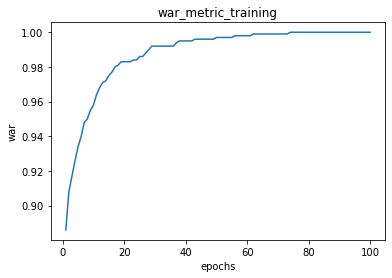

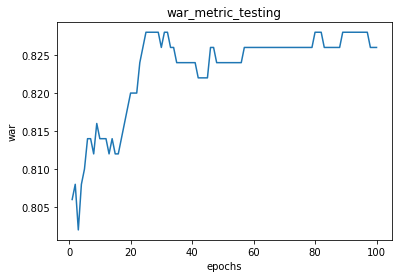

best score for war_metric_training is 1.0.
best score for war_metric_testing is 0.828.


In [28]:
epochs = 100
eta = 0.1
batch_size = 64
# Workspace 3.6
#BEGIN 
# code here
multiclass_logistic_regression_1 = OneVersusAll(eta=0.1, alpha=0)
war_metric_training = multiclass_logistic_regression_1.fit(digits.X_train, digits.y_train, batch_size=64, epochs=100)

multiclass_logistic_regression_2 = OneVersusAll(eta=0.1, alpha=0)
war_metric_testing = multiclass_logistic_regression_2.fit(digits.X_train, digits.y_train, batch_size=64, epochs=100, validation_X=digits.X_test, validation_y=digits.y_test)

plt.title("war_metric_training")
plt.xlabel("epochs")
plt.ylabel("war")
plt.plot(list(range(1, epochs+1)), war_metric_training)
plt.show()

plt.title("war_metric_testing")
plt.xlabel("epochs")
plt.ylabel("war")
plt.plot(list(range(1, epochs+1)), war_metric_testing)
plt.show()

print("best score for war_metric_training is {}.".format(max(war_metric_training)))
print("best score for war_metric_testing is {}.".format(max(war_metric_testing)))
#END

- 3.7 **[3 points]** Does the WAR improve as we train for more epochs on the two data partitions (train, test)? Why? How does it compare to KNNClassifier? How do you explain the difference?

% Workspace 3.7

%BEGIN

As you can see from the graphs above, WAR improves as we train more epochs on training dataset, and it eventually reaches 1.0 WAR score. However, WAR improves to a certain point for testing dataset and starts degrading beyond the point due to the model being overfitting. The performance of Logistic Regressions(binary or One versus all) depend on the number of epochs, batch size, and learning rate. KNNClassifier's performance, on the other hand, is primarily determined by the number of nearest neighbors and the distance metrics used to calculate data point similarity. Logistic Regression and KNNClassifier have different hyperparameters to optimize the performance.

%END

- 3.8 **(Bonus)** **[3 points]** Repeat 3.6 and 3.7 using Ridge regularization for the LogisticRegression classifiers with alpha=0.01. How does the regularization affect the performance on train VS test sets?

You have to answer 2.10 before you attempt this question.

In [31]:
epochs = 100
eta = 0.1
batch_size = 64
alpha = 1e-2
# Workspace 3.8 (code)
#BEGIN 
# code here
#END

#### Workspace 3.8 (write up)

%BEGIN

% YOUR ANSWER HERE

%END

## Problem 4: Naive Bayes (17 points)
***
Consider the problem of predicting whether your TA will be late to campus in the morning based off the weather, temperature, and whether they biked or took the bus.
The dataset looks like the following:

|Snowing |Raining |Below Freezing |Bike or Bus |Late |
|:------:|:-----------:| :----------:| :----------:|--:|
| Yes | No | Yes | Bus  | Yes |
| No | No | No | Bicycle | No |
| No | Yes | No | Bicycle | Yes |
| No | No | No | Bus | Yes |
| No | No | No | Bicycle | No |
| No | No | Yes | Bicycle | No |
| No | No | Yes | Bicycle | Yes |
| Yes | Yes | Yes | Bus | No |
| No | Yes | No | Bus | Yes |
| No | Yes | No | Bicycle | No |
| No | No | No | Bicycle | No |
| Yes | No | Yes | Bicycle | Yes |


In [29]:
features = np.array([
    [1, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 1, 0, 1],
    [0, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 1],
    [0, 0, 1, 1],
    [1, 1, 1, 0],
    [0, 1, 0, 0],
    [0, 1, 0, 1],
    [0, 0, 0, 1],
    [1, 0, 1, 1]
])

labels = np.array([1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1])

n_samples, n_features = features.shape
feature_names = ["snowing", "raining", "below freezing", "bike"]
prob_late = np.count_nonzero(labels == 1) / n_samples
print("probability of TA being late: {}".format(prob_late))
print("                ")

for i in range(n_features):
    prob_feature = np.count_nonzero(features[:, i] == 1) / n_samples
    print("probability of {}: {}".format(feature_names[i], prob_feature))
    prob_feature_late = np.sum(features[:, i] * labels) / np.count_nonzero(labels == 1)
    print("probability of {} when TA late: {}".format(feature_names[i], prob_feature_late))
    prob_late_feature = (prob_feature_late * prob_late) / prob_feature
    print("probability of the TA being late to campus when {} is {}".format(feature_names[i], prob_late_feature))
    print("                      ")


probability of TA being late: 0.5
                
probability of snowing: 0.25
probability of snowing when TA late: 0.3333333333333333
probability of the TA being late to campus when snowing is 0.6666666666666666
                      
probability of raining: 0.3333333333333333
probability of raining when TA late: 0.3333333333333333
probability of the TA being late to campus when raining is 0.5
                      
probability of below freezing: 0.4166666666666667
probability of below freezing when TA late: 0.5
probability of the TA being late to campus when below freezing is 0.6
                      
probability of bike: 0.6666666666666666
probability of bike when TA late: 0.5
probability of the TA being late to campus when bike is 0.375
                      


4.1 [2 points] If we were to use only one binary feature (Snowing, Raining, Below Freezing, Bike or Bus)
then what's the highest accuracy we could achieve? Which feature should we use?

**Workspace 4.2**

#BEGIN

probability of TA being late: 0.5
                
probability of snowing: 0.25

probability of snowing when TA late: 0.3333333333333333

probability of the TA being late to campus when snowing is 0.6666666666666666
                      
probability of raining: 0.3333333333333333

probability of raining when TA late: 0.3333333333333333

probability of the TA being late to campus when raining is 0.5
                      
probability of below freezing: 0.4166666666666667

probability of below freezing when TA late: 0.5

probability of the TA being late to campus when below freezing is 0.6
                      
probability of bike: 0.6666666666666666

probability of bike when TA late: 0.5

probability of the TA being late to campus when bike is 0.375

Therefore, the highest accuracy we could achieve is 0.666 when it's snowing. We should use snowing. 

#END

## How to implement NaiveBayes
Recall Bayes' Theorem, which states the following:
\begin{align}
P(y | X) = \frac{P(X | y) P(y)}{P(X)}
\end{align}

We refer to $P(y | X)$ as the posterior, $P(X|y)$ as the class-conditional, $P(y)$ as the prior, and $P(X)$ as the evidence.

As seen during the class, given a sample $(x_1, x_2, x_3)$, the naive Bayes classifier should assign the label $y$ that
maximizes:

\begin{align}
\log [p(y) \prod_i p(x_i | y)] = \log p(y) + \sum_{i} \log p(x_i | y)
\end{align}

$p(y)$ and $p(x_i | y)$ are computed using the training set (during `fit` call).

For this, we need two attributes to store
$\log p(y)$ and $\log p(x_i | y)$ for different features $i$.

Let's assume we're working with binary classes $\{0, 1\}$ and all features have discrete supports.
Then we will store our log prior, `classes_log_probability`, as an array of shape `(2,)` that contains:
\begin{bmatrix}
\log p(y=0),\log p(y=1)
\end{bmatrix}.

Here, $p(y=1)$ is just the fraction of the time that y is 1 in the training set.

If feature $i$ has $2$ possible values $\{0, 1\}$, then we want to store our log class-conditional, $\log p(x_i | y)$, as a $ 2 \times 2$ matrix:
\begin{align}
A_i = \begin{bmatrix}
\log p(x_i=0 | y=0) & \log p(x_i=1| y=0)\\
\log p(x_i=0 | y=1) & \log p(x_i=1 | y=1)
\end{bmatrix}
\end{align}

`features_log_likelihood` should then store such matrix for each feature.

We have defined $p(x_i | y)$ as :
\begin{align}
p(x_i | y) = \frac{N_{y,x_i}}{N_y}
\end{align}
where $N_{y,i}$ is the number of instances where $y$ and $x_i$ occur together, and $N_y = \sum_i N_{y,x_i}$.

4.2 [2 points] Complete the method `compute_classes` and store the log prior in `classes_log_probability`

4.3 [5 points] Complete the method `compute_features` by storing the matrices $A_i$ in `self.features_log_likelihood`. We need one matrix for each feature.

4.4  Study the method `joint_log_likelihood`. You will need to use this to complete Naive Bayes. Note that it computes the likelihood quantities
 $[\sum_{i} \log p(x_i | y=0), \sum_{i} \log p(x_i | y=1)]$ for each observation

4.5 [3 points] Complete the `predict` method

In [30]:

class NaiveBayes(object):
    """
    NaiveBayes classifier for binary features and binary labels
    """

    def __init__(self, alpha=0.0):
        self.alpha = alpha
        self.classes_counts = None
        self.classes_log_probability = np.empty((2,))
        self.features_log_likelihood = []  # list of arrays where element i store log p(X[:,i], y)

    def compute_classes(self, y):
        """
        Computes the log prior of binary classes and stores the result in self.classes_log_probability
        :param y: binary labels array, shape (m,)
        """
        # Workspace 4.2
        #BEGIN 
        # code here
        self.classes_log_probability[0] = np.log(np.count_nonzero(y == 0) / len(y))
        self.classes_log_probability[1] = np.log(np.count_nonzero(y == 1) / len(y))
        #END

    def compute_features(self, X, y):
        """
        Computes the log likelihood matrices for different features and stores them in self.features_log_likelihood
        :param X: data matrix with binary features, shape (n_samples, n_features)
        :param y: binary labels array, shape (n_samples,)
        """
        # Workspace 4.3
        #BEGIN 
        # code here
        n_samples, n_features = X.shape
        
        X_unique, X_counts = np.unique(X, return_counts=True)
        y_unique, y_counts = np.unique(y, return_counts=True)
        
        count_of_y_0 = np.count_nonzero(y == 0)
        count_of_y_1 = np.count_nonzero(y == 1)
        
        for i in range(n_features):
            Ai = np.zeros((len(X_unique), len(y_unique)))
            
            # 𝑝(𝑥𝑖=0|𝑦=0)
            count_of_x_0_and_y_0 = 0
            # 𝑝(𝑥𝑖=0|𝑦=1)            
            count_of_x_0_and_y_1 = 0
            # 𝑝(𝑥𝑖=1|𝑦=0)
            count_of_x_1_and_y_0 = 0
            # 𝑝(𝑥𝑖=1|𝑦=1)
            count_of_x_1_and_y_1 = 0
            
            for index in range(n_samples):
                if X[index, i] == 0 and y[index] == 0:
                    count_of_x_0_and_y_0 += 1
                if X[index, i] == 0 and y[index] == 1:
                    count_of_x_0_and_y_1 += 1
                if X[index, i] == 1 and y[index] == 0:
                    count_of_x_1_and_y_0 += 1
                if X[index, i] == 1 and y[index] == 1:
                    count_of_x_1_and_y_1 += 1
            
            Ai[0, 0] = np.log(count_of_x_0_and_y_0 / count_of_y_0)
            Ai[0, 1] = np.log(count_of_x_1_and_y_0 / count_of_y_0)
            Ai[1, 0] = np.log(count_of_x_0_and_y_1 / count_of_y_1)
            Ai[1, 1] = np.log(count_of_x_1_and_y_1 / count_of_y_1)
            
            self.features_log_likelihood.append(Ai)
        
        #END

    def fit(self, X, y):
        """
        :param X: binary np.array of shape (n_samples, n_features) [values 0 or 1]
        :param y: corresponding binary labels of shape (n_samples,) [values 0 or 1]
        :return: Classifier
        """
        self.compute_classes(y)
        self.compute_features(X, y)
        return self

    def joint_log_likelihood(self, X):
        """
        Computes the joint log likelihood
        :param X: binary np.array of shape (n_samples, n_features) [values 0 or 1]
        :return: joint log likelihood array jll of shape (n_samples, 2), where jll[i] = [log p(X[i]|y=0),log p(X[i]|y=1)]
        """
        joint_log_likelihood = np.zeros((X.shape[0], self.classes_log_probability.shape[0]))
        for f in range(len(self.features_log_likelihood)):
            joint_log_likelihood += self.features_log_likelihood[f][:, X[:, f]].T
        return joint_log_likelihood

    def predict(self, X):
        """
        :param X:
        :return:
        """

        # Workspace 4.5
        # TODO: Find the corresponding labels using Naive bayes logic
        # inc y_hat = np.zeros((X.shape[0],))
        #BEGIN 
        # code here
        joint_log_likelihood = self.joint_log_likelihood(X)
        y_hat = np.argmax(joint_log_likelihood, axis=1)
        #END

        return y_hat

In [31]:
# Test cell, uncomment to run the tests
%run -i tests naivebayes

....
----------------------------------------------------------------------
Ran 4 tests in 0.004s

OK


<Figure size 432x288 with 0 Axes>

4.6 [5 points] Using snowing and bike or bus, transform the features and evaluate (accuracy) the NaiveBayes classifier
on the training data. Does it outperform our baseline (of using one feature)?

In [32]:
naive_bayes = NaiveBayes()
# Workspace 4.6
#TODO: Transform features to binary features, fit the classifier, report the accuracy
#BEGIN 
# code here
naive_bayes.fit(features, labels)
y_hat = naive_bayes.predict(features)

correct = 0
for i in range(len(labels)):
    if labels[i] == y_hat[i]:
        correct += 1
accuracy = correct / len(labels)

print("accuracy for naitve bayes classifier on the training data is {}".format(accuracy))
#END

accuracy for naitve bayes classifier on the training data is 0.75


The highest accuracy we could achieve with one feature is 0.666 when it's snowing. Whereas, the NaiveBayes classifier has accuracy of 0.75. It definitely outperforms our baseline.   


**Bonus**

4.7 [2 points] Use the attribute `alpha` of the NaiveBayes to convert it to smoothed NaiveBayes presented during the class.
`alpha`defaults to 0, so editing the class should not affect NaiveBayes tests